# Обработка входных данных

In [1]:
import os
import zipfile
from pathlib import Path
from random import shuffle
from PIL import Image
import shutil
import torch
import torchvision

# Configurations
BALANCED_SIZE = 12500
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
from torchvision import transforms

img_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

img_test_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

# Обучаем сетки

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset

#### Поделим данные и переведём в тензоры

#### Функции для обучения

In [4]:
import matplotlib.pyplot as plt
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [5]:
def train(model, opt, criterion, n_epochs, train_loader, val_loader, save_path, all_classes=True):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    best_val_loss = float('inf')
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        print("Training...")
        train_loss, train_acc = train_epoch(model, opt, criterion, train_loader, batchsize=BATCH_SIZE)
        print("Done\nValidating...")
        val_loss, val_acc = test(model, criterion, val_loader)
        print("Done")
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        x = 4 if all_classes else 2
        steps = (BALANCED_SIZE * x * 0.6) / BATCH_SIZE
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log, title=f'loss in {"Cats & Dogs vs Others" if all_classes else "Cats vs Dogs"} for {model.name}')    
        plot_history(train_acc_log, val_acc_log, title=f'accuracy in {"Cats & Dogs vs Others" if all_classes else "Cats vs Dogs"} for {model.name}')  
        print(f"Loss: {np.mean(val_loss)}")
        print(f"Acc: {np.mean(val_acc)}")
        if np.mean(val_loss) < best_val_loss:
            best_val_loss = np.mean(val_loss)
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved")

In [25]:
def test(model, criterion, test_loader):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):   
        print(f"Batch {batch_num+1}/{len(test_loader)}")
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        data = Variable(x_batch).to(device)
        target = Variable(y_batch)
        target = target.type(torch.LongTensor) 
        target = target.to(device)

        output = model(data)
        loss = criterion(output, target).cuda()

        pred = torch.argmax(output, dim=1, keepdim = True).reshape(data.shape[0]).data.cuda()
        acc = np.mean((pred == y_batch).cpu().numpy())
        
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    print(loss_log)
    return loss_log, acc_log

In [7]:
def train_epoch(model, optimizer, criterion, train_loader, batchsize=32): 
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        print(f"Batch {batch_num+1}/{len(train_loader)}")
        x_batch = x_batch.to(device)
        # y_batch = torch.unsqueeze(y_batch, 1)
        y_batch = y_batch.to(device)
        # print(y_batch.shape)
        data = Variable(x_batch).to(device)
        target = Variable(y_batch)
        target = target.type(torch.LongTensor) 
        target = target.to(device)
        # print(y_batch.shape)
        # print(target.shape)

        output = model(data)
        pred = torch.argmax(output, dim=1, keepdim = True).reshape(data.shape[0]).data.cuda()
        acc = np.mean((pred == y_batch).cpu().numpy())
        acc_log.append(acc)
        
        loss = criterion(output, target).cuda()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        optimizer.zero_grad()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log   

#### Обучение сетей

In [8]:
import torch
import torch.nn as nn
from torchvision import models

class VGG16(nn.Module):
    def __init__(self, num_classes, name):
        super(VGG16, self).__init__()
        
        self.name = name
        
        # Load pretrained VGG16 model
        self.base_model = models.vgg16(pretrained=True)
        
        # Freeze feature extractor layers
        for name, param in self.base_model.named_parameters():
            param.requires_grad = False
        
        # Replace classifier
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier[0].in_features, 4096),  # First FC layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 256),         # Second FC layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)      # Output layer
        )
        
        # Initialize new layers
        for layer in self.base_model.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
    
    def forward(self, x):
        return self.base_model(x)

class VGG19(nn.Module):
    def __init__(self, num_classes, name):
        super(VGG19, self).__init__()

        self.name = name

        # Load pretrained VGG19 model
        self.base_model = models.vgg19(pretrained=True)
        
        # Freeze the feature extractor layers
        for name, param in self.base_model.named_parameters():
            param.requires_grad = False
        
        # Replace the classifier with a custom one
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier[0].in_features, 4096),  # First FC layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 256),         # Second FC layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)      # Output layer
        )
        
        # Initialize the weights of the custom layers
        for layer in self.base_model.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
    
    def forward(self, x):
        return self.base_model(x)

In [9]:
class ResNet18(nn.Module):
    def __init__(self, num_classes, name):
        super(ResNet18, self).__init__()
        
        self.name = name
        
        # Load pretrained ResNet18
        self.base_model = models.resnet18(pretrained=True)
        
        # Freeze feature extractor layers
        for name, param in self.base_model.named_parameters():
            if "bn" not in name:
                param.requires_grad = False
        
        self.base_model.fc = nn.Sequential(nn.Linear(self.base_model.fc.in_features,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))
    
    def forward(self, x):
        return self.base_model(x)


class ResNet34(nn.Module):
    def __init__(self, num_classes, name):
        super(ResNet34, self).__init__()

        self.name = name
        
        # Load pretrained ResNet34
        self.base_model = models.resnet34(pretrained=True)
        
        # Freeze feature extractor layers
        for name, param in self.base_model.named_parameters():
            if "bn" not in name:
                param.requires_grad = False
        
        self.base_model.fc = nn.Sequential(nn.Linear(self.base_model.fc.in_features,512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512, num_classes))
    
    def forward(self, x):
        return self.base_model(x)


### Обучение классификаторов "Кошки и Собаки vs Остальное"

In [10]:
criterion = nn.CrossEntropyLoss()

In [14]:
train_data_path = "processed_data/Task1/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms)

val_data_path = "processed_data/Task1/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_test_transforms)

test_data_path = "processed_data/Task1/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_test_transforms)

num_workers = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [ ]:
print("Training VGG16 for task 1")
modelVGG16_1 = VGG16(num_classes=2, name='VGG16').to(device)
optimizerVGG16_1 = optim.Adam(modelVGG16_1.parameters(), lr=0.001)
train(modelVGG16_1, optimizerVGG16_1, criterion, EPOCHS, train_loader, val_loader, 'catsdogs_vs_others_VGG16.pth', )

modelVGG16_1.load_state_dict(torch.load('catsdogs_vs_others_VGG16.pth', weights_only=True))

In [ ]:
print("Training VGG19 for task 1")
modelVGG19_1 = VGG19(num_classes=2, name='VGG19').to(device)
optimizerVGG19_1 = optim.Adam(modelVGG19_1.parameters(), lr=0.001)
train(modelVGG19_1, optimizerVGG19_1, criterion, EPOCHS, train_loader, val_loader, 'catsdogs_vs_others_VGG19.pth', )

modelVGG19_1.load_state_dict(torch.load('catsdogs_vs_others_VGG19.pth', weights_only=True))

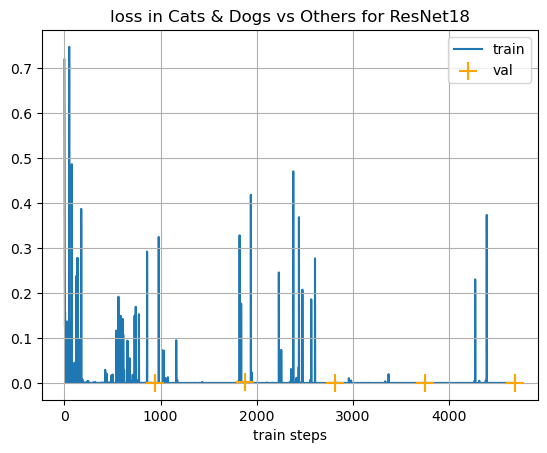

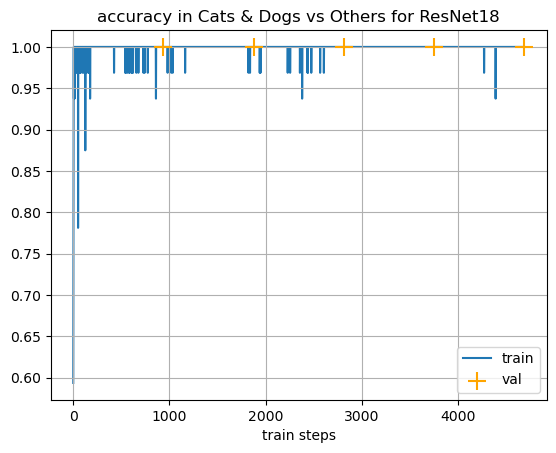

Loss: 0.0
Acc: 1.0


<All keys matched successfully>

In [15]:
print("Training ResNet18 for task 1")
modelResNet18_1 = ResNet18(num_classes=2, name='ResNet18').to(device)
optimizerResNet18_1 = optim.Adam(modelResNet18_1.parameters(), lr=0.001)
train(modelResNet18_1, optimizerResNet18_1, criterion, EPOCHS, train_loader, val_loader, 'catsdogs_vs_others_ResNet18.pth', )

modelResNet18_1.load_state_dict(torch.load('catsdogs_vs_others_ResNet18.pth', weights_only=True))

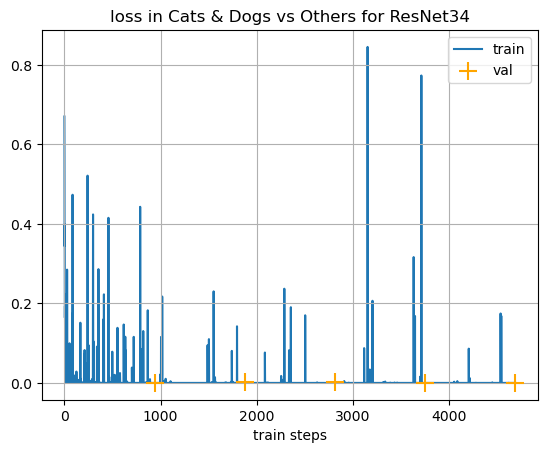

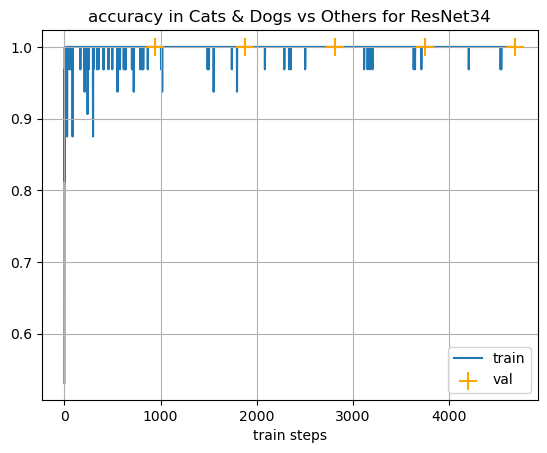

Loss: 3.67195667603741e-05
Acc: 1.0


<All keys matched successfully>

In [16]:
print("Training ResNet34 for task 1")
modelResNet34_1 = ResNet34(num_classes=2, name='ResNet34').to(device)
optimizerResNet34_1 = optim.Adam(modelResNet34_1.parameters(), lr=0.001)
train(modelResNet34_1, optimizerResNet34_1, criterion, EPOCHS, train_loader, val_loader, 'catsdogs_vs_others_ResNet34.pth', )

modelResNet34_1.load_state_dict(torch.load('catsdogs_vs_others_ResNet34.pth', weights_only=True))

In [27]:
test_data_path = "processed_data/Task1/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

loss1, acc1 = test(modelResNet34_1, criterion, test_loader)
clear_output()
loss2, acc2 = test(modelResNet18_1, criterion, test_loader)
clear_output()

NameError: name 'loss' is not defined

In [31]:
print(f"ResNet34\nLoss: {np.mean(loss1)}\nAcc: {np.mean(acc1)}\n")
print(f"ResNet18\nLoss: {np.mean(loss2)}\nAcc: {np.mean(acc2)}\n")

models_ensemble = [modelResNet18_1, modelResNet34_1]

correct = 0
total = 0
with torch.no_grad():
    for batch_num, data in enumerate(test_loader):
        print(f'Batch {batch_num+1}/{len(test_loader)}')
        images, labels = data[0].to(device), data[1].to(device)
        predictions = [i(images).data for i in models_ensemble]
        avg_predictions = torch.mean(torch.stack(predictions), dim=0)
        _, predicted = torch.max(avg_predictions, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
clear_output()
# print('correct: {:d}  total: {:d}'.format(correct, total))

NameError: name 'loss' is not defined

In [33]:
print(f"ResNet34\nLoss: {np.mean(loss1)}\nAcc: {np.mean(acc1)}\n")
print(f"ResNet18\nLoss: {np.mean(loss2)}\nAcc: {np.mean(acc2)}\n")
print(f'Ensemble\nAcc: {correct / total}')
print(correct, total)

ResNet34
Loss: 0.00038246510506527323
Acc: 0.9999001597444089

ResNet18
Loss: 0.0017427442410882013
Acc: 0.9999001597444089

Ensemble
Acc: 0.9999
9999 10000


### Обучение классификаторов "Кошки vs Собаки"

In [19]:
train_data_path = "processed_data/Task2/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms)

val_data_path = "processed_data/Task2/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_test_transforms)

test_data_path = "processed_data/Task2/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_test_transforms)

num_workers = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [ ]:
print("Training VGG16 for task 2")
modelVGG16_2 = VGG16(num_classes=2, name='VGG16').to(device)
optimizerVGG16_2 = optim.Adam(modelVGG16_2.parameters(), lr=0.001)
train(modelVGG16_2, optimizerVGG16_2, criterion, EPOCHS, train_loader, val_loader, 'cats_vs_dogs_VGG16.pth', all_classes=False)

modelVGG16_2.load_state_dict(torch.load('cats_vs_dogs_VGG16.pth', weights_only=True))

In [ ]:
print("Training VGG19 for task 2")
modelVGG19_2 = VGG19(num_classes=2, name='VGG19').to(device)
optimizerVGG19_2 = optim.Adam(modelVGG19_2.parameters(), lr=0.001)
train(modelVGG19_2, optimizerVGG19_2, criterion, EPOCHS, train_loader, val_loader, 'cats_vs_dogs_VGG19.pth', all_classes=False)

modelVGG19_2.load_state_dict(torch.load('cats_vs_dogs_VGG19.pth', weights_only=True))

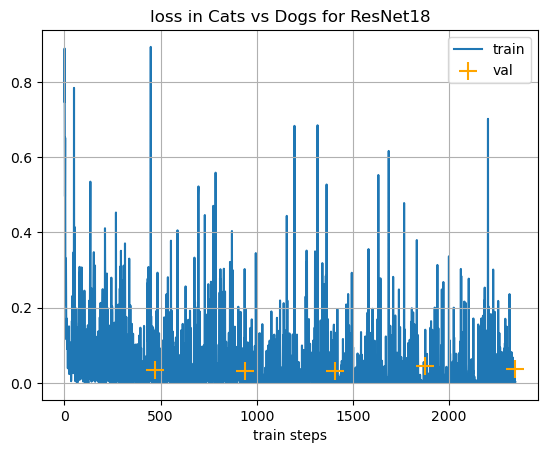

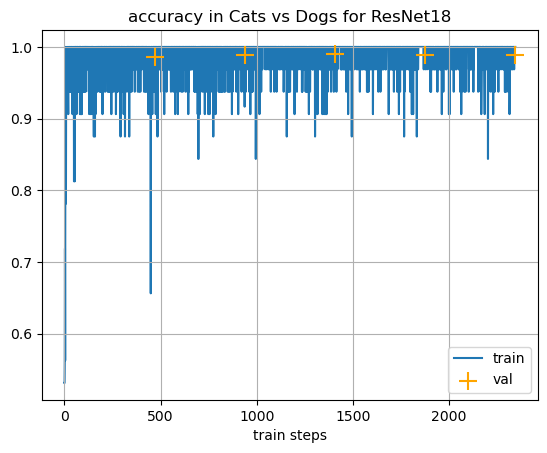

Loss: 0.03708225967595117
Acc: 0.9888535031847133


<All keys matched successfully>

In [20]:
print("Training ResNet18 for task 2")
modelResNet18_2 = ResNet18(num_classes=2, name='ResNet18').to(device)
optimizerResNet18_2 = optim.Adam(modelResNet18_2.parameters(), lr=0.001)
train(modelResNet18_2, optimizerResNet18_2, criterion, EPOCHS, train_loader, val_loader, 'cats_vs_dogs_ResNet18.pth', all_classes=False)

modelResNet18_2.load_state_dict(torch.load('cats_vs_dogs_ResNet18.pth', weights_only=True))

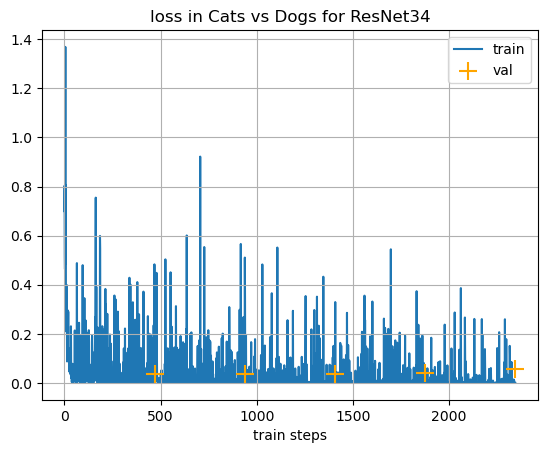

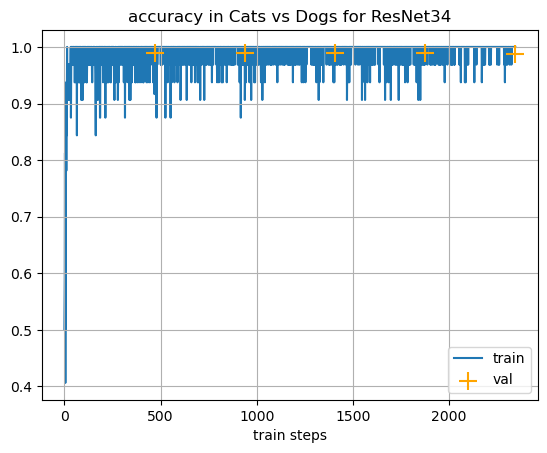

Loss: 0.058508613729447864
Acc: 0.9872611464968153


<All keys matched successfully>

In [21]:
print("Training ResNet34 for task 2")
modelResNet34_2 = ResNet34(num_classes=2, name='ResNet34').to(device)
optimizerResNet34_2 = optim.Adam(modelResNet34_2.parameters(), lr=0.001)
train(modelResNet34_2, optimizerResNet34_2, criterion, EPOCHS, train_loader, val_loader, 'cats_vs_dogs_ResNet34.pth', all_classes=False)

modelResNet34_2.load_state_dict(torch.load('cats_vs_dogs_ResNet34.pth', weights_only=True))

In [35]:
test_data_path = "processed_data/Task2/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

loss1, acc1 = test(modelResNet34_2, criterion, test_loader)
clear_output()
loss2, acc2 = test(modelResNet18_2, criterion, test_loader)
clear_output()

print(f"ResNet34\nLoss: {np.mean(loss1)}\nAcc: {np.mean(acc1)}\n")
print(f"ResNet18\nLoss: {np.mean(loss2)}\nAcc: {np.mean(acc2)}\n")

models_ensemble = [modelResNet18_2, modelResNet34_2]

correct = 0
total = 0
with torch.no_grad():
    for batch_num, data in enumerate(test_loader):
        print(f'Batch {batch_num+1}/{len(test_loader)}')
        images, labels = data[0].to(device), data[1].to(device)
        predictions = [i(images).data for i in models_ensemble]
        avg_predictions = torch.mean(torch.stack(predictions), dim=0)
        _, predicted = torch.max(avg_predictions, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
clear_output()
# print('correct: {:d}  total: {:d}'.format(correct, total))

print(f"ResNet34\nLoss: {np.mean(loss1)}\nAcc: {np.mean(acc1)}\n")
print(f"ResNet18\nLoss: {np.mean(loss2)}\nAcc: {np.mean(acc2)}\n")
print(f'Ensemble\nAcc: {correct / total}')
print(correct, total)

ResNet34
Loss: 0.028881096340631008
Acc: 0.9922372611464968

ResNet18
Loss: 0.032228787811664876
Acc: 0.9892515923566879

Ensemble
Acc: 0.9932
4966 5000


In [ ]:
def denormalize_image(tensor, mean, std):
    """
    tensor: Тензор изображения [C, H, W]
    mean: Список средних значений нормализации
    std: Список стандартных отклонений нормализации
    """
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    image = tensor.cpu().numpy()  # Перевод в numpy
    image = (image * std) + mean  # Отмена нормализации
    image = np.clip(image, 0, 1)  # Обрезаем значения в диапазоне [0, 1]
    return image

In [ ]:
import time

test_loader = make_loader(test_data, batch_size=1)
# print(test_loader)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]